In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
import re

In [2]:
# obtain file names
years = [2013,2014,2015,2016,2017,2018]
file_directory = '/Users/yuxinchen/Documents/Research/data_projects/data/health_ranks_data/csv_files/*.csv'
import glob
files = sorted(glob.glob(file_directory, recursive=True))

In [3]:
def create_df_list(files):
    """ 
    obtain dataframes from the csv files and remove some unnecessary columns
    
    Args:
        - (Python list of strings): list of absolute filepaths to data csv's
    Returns:
        - (list of Pandas DataFrames): list of DataFrames each one representing state level data for a specific year
    """ 

    dfs = []
    df_columns = []
    unnecessary_columns = ['95% CI', 'Z-Score']
    for file in files:
        df = pd.read_csv(file)
        columns = df.columns.values
        # remove unnecessary columns
        for string in unnecessary_columns:
            cols_to_keep = [c for c in df.columns.values if not string in c]        
            df = df[cols_to_keep]
        dfs.append(df)
    
    return dfs
dfs = create_df_list(files)

In [4]:
dfs[0].columns.values

array(['Unnamed: 0', 'FIPS', 'State', 'County', 'Rank', 'Rank.1',
       'Rank.2', 'Rank.3', 'Rank.4', 'Rank.5', 'Rank.6', 'Rank.7',
       'Rank.8', 'Rank.9', 'Rank.10', 'Rank.11', 'Rank.12', 'Deaths',
       'YPLL Rate', 'Sample Size', '% Fair/Poor', 'Sample Size.1',
       'Physically Unhealthy Days', 'Sample Size.2',
       'Mentally Unhealthy Days', 'Unreliable', 'LBW Births',
       'Live Births', '% LBW', 'Sample Size.3', '% Smokers', '% Obese',
       '% Physically Inactive', 'Sample Size.4', '% Excessive Drinking',
       'Motor Vehicle Deaths', 'MV Mortality Rate', 'Chlamydia Cases',
       'Chlamydia Rate', 'Teen Births ', 'Teen Population',
       'Teen Birth Rate', '# Uninsured', '% Uninsured', '# PCP',
       'PCP Rate', 'PCP Ratio', '# Dentists', 'Dentist Rate',
       'Dentist Ratio', '# Medicare enrollees', 'ACSC Rate',
       '# Diabetics', '% HbA1c', '# Medicare Enrollees', '% Mammography',
       'AFGR', '# Some College', 'Population', '% Some College',
       '# Un

In [5]:
# find intersection of columns in dfs
def find_column_intersection(dfs):
    """
    find all shared columns among the DataFrames in dfs
    
    Args:
        - (list of Pandas DataFrames): list of DataFrames each one representing state level data for a specific yearl
    Returns:
        - (list of Python strings): list of shared column names
    """
    col_list = []
    for df in dfs:
        col = df.columns.values
        col_list.append(col)
    from functools import reduce
    common_cols = list(reduce(set.intersection, [set(item) for item in col_list ]))
    return common_cols
common_cols = find_column_intersection(dfs)
len(common_cols)

39

In [6]:
# remove the columns in each dataframe of dfs that are not in common_cols
for ind, df in enumerate(dfs):
    df = df.loc[:,common_cols]
    dfs[ind] = df

In [7]:
# combine all dataframes into one
df = pd.concat(dfs)
# drop duplicated columns
df.drop(['Physically Unhealthy Days', 'Unnamed: 0', '# Some College', 'Dentist Ratio', '# Dentists','PCP Ratio', '# Households', '# Unemployed','# Uninsured','# Single-Parent Households', '# Limited Access'], axis = 1, inplace = True)


In [8]:
# convert columns that have number into population percentage
for col in df.columns.values:
    if '#' in col:
        df[col] = df[col]/df['Population']

### Correlation heatmap

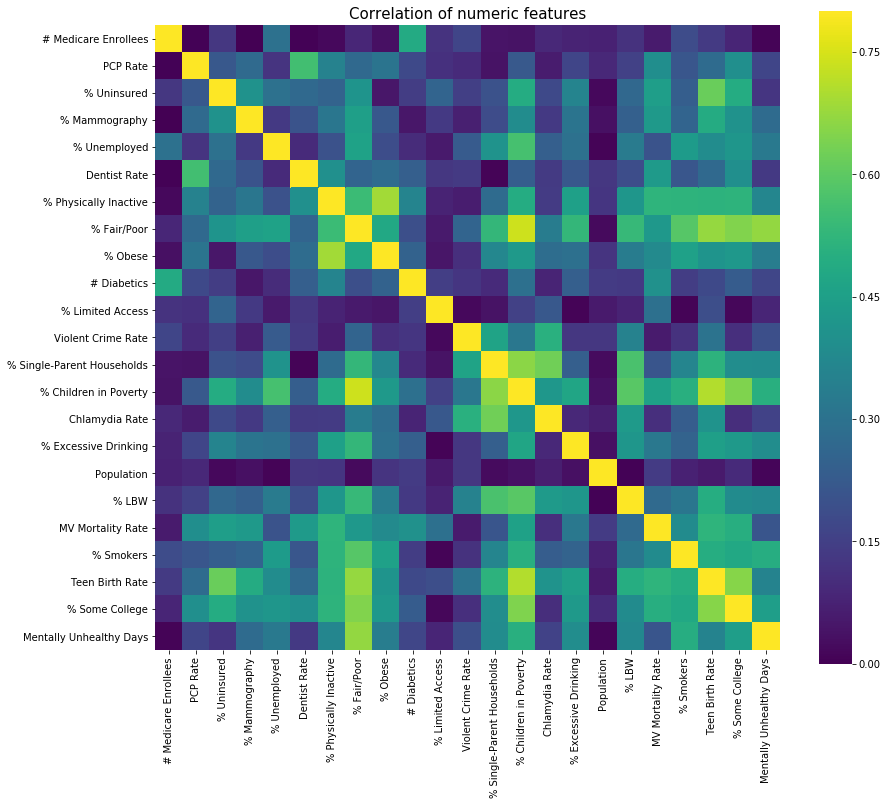

In [9]:
def make_correlation_matrix(df):
    """
    compute a pairwise correlation matrix for a DataFrame of numerical values (based on selecting numerical dtypes)
    
    Args:
        - (Pandas DataFrame): input df (may contain columns with categorical values)
    Returns:
        - (Pandas DataFrame): pairwise correlation coefficient matrix for all columns from input df
    """
    correlation = df.select_dtypes(include=[np.number]).corr()
    
    return correlation
correlation = make_correlation_matrix(df.loc[:, (df.columns!='FIPS') & (df.columns!='Labor Force')])
f , ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of numeric features',size=15)
sns.heatmap(np.abs(correlation),square = True,  vmin = 0, vmax=0.8, cmap = 'viridis')

### Observe in the heatmap that some effective variables might be % Mammography, Dentist Rate, Teen Birth Rate, % Physically Inactive, Mentally Unhealthy Days, % Children in Poverty, % LBW, # Diabetics, Violent Crime Rate, % Unemployerd, % Single-Parent Households, % Smokers, Physically Unhealthy Days, % Uninsured, % Excessive Drinking, % Some College, % Obese

In [10]:
print(np.abs(correlation['% Fair/Poor']).sort_values(ascending = False))

% Fair/Poor                   1.000000
% Children in Poverty         0.738279
Teen Birth Rate               0.672160
Mentally Unhealthy Days       0.669626
% Some College                0.646909
% Smokers                     0.588048
% Physically Inactive         0.545918
% LBW                         0.536610
% Excessive Drinking          0.530703
% Single-Parent Households    0.529530
% Obese                       0.481158
% Unemployed                  0.459879
% Mammography                 0.448961
MV Mortality Rate             0.425903
% Uninsured                   0.413689
Chlamydia Rate                0.334290
PCP Rate                      0.271872
Dentist Rate                  0.255753
Violent Crime Rate            0.254086
# Diabetics                   0.192649
# Medicare Enrollees          0.085284
% Limited Access              0.054390
Population                    0.021324
Name: % Fair/Poor, dtype: float64


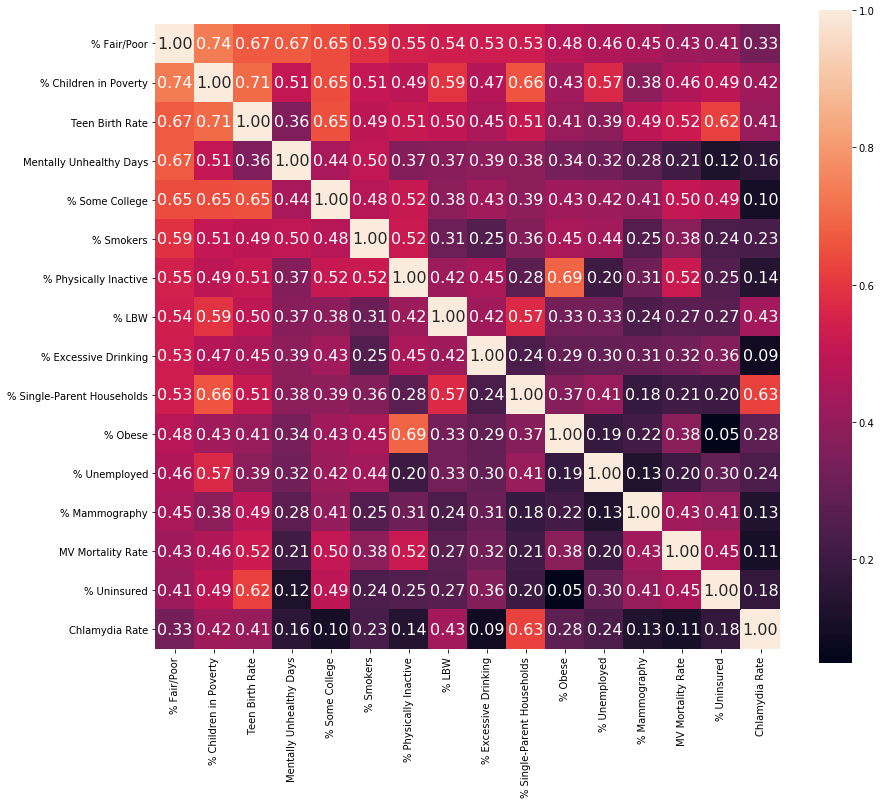

In [11]:
#zoomed in correlation matrix
f , ax = plt.subplots(figsize = (14,12))
k = 16 #number of variables for heatmap
cols = abs(correlation).nlargest(k, '% Fair/Poor')['% Fair/Poor'].index
cor = df.loc[:, cols].select_dtypes(include = [np.number]).corr()
sns.heatmap(np.abs(cor),cbar=True,square = True,annot=True, fmt='.2f', annot_kws={'size': 16}, yticklabels=cols.values, xticklabels=cols.values)
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 16}, yticklabels=cols.values, xticklabels=cols.values)

### Dealing with missing data

In [12]:
def count_dataframe_null_values(df):
    """
    calculates the number of null values for every column in input df, and associated percentage relative to total column size
    
    Args:
        - (Pandas DataFrame): df to inspect for null values
    Returns:
        - (Pandas DataFrame): sorted df containing two columns: total number of null values per column, and percentage of null values relative to total size of column 
    """
    
    total = df.isnull().sum().sort_values(ascending=False)

    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    return missing_data

missing_data = count_dataframe_null_values(df)
print("missing_data: \n", missing_data)

missing_data: 
                             Total   Percent
Unreliable                  17693  0.981853
MV Mortality Rate            2628  0.145838
% Excessive Drinking         2474  0.137292
% Smokers                    1698  0.094229
Mentally Unhealthy Days      1618  0.089789
% Fair/Poor                  1442  0.080022
Violent Crime Rate           1266  0.070255
Chlamydia Rate               1130  0.062708
% LBW                        1098  0.060932
PCP Rate                     1052  0.058380
Teen Birth Rate               972  0.053940
# Medicare Enrollees          881  0.048890
% Mammography                 844  0.046837
Dentist Rate                  729  0.040455
County                        539  0.029911
# Diabetics                   532  0.029523
% Limited Access              287  0.015927
% Single-Parent Households    281  0.015594
% Children in Poverty         277  0.015372
% Unemployed                  277  0.015372
Labor Force                   277  0.015372
% Uninsured     

In [13]:
# delete the variable with more than 15% missing data
def drop_corrupted_columns(df, threshold=0.15):
    """
    drop columns in given df if percent of missing values is greater than threshold
    
    Args:
        - (Pandas DataFrame): input df
        - (Python float): threshold to drop columns (default = 0.15)
    Returns:
        - (Pandas DataFrame): reduced df
    """
    df = df.drop((missing_data[missing_data['Percent'] > threshold]).index,1)
    return df

df = drop_corrupted_columns(df, threshold=0.15)

In [14]:
# delete rows with missing data
# alternatively, replace the missing value with average value across years in the associated county or treat it accordingly
# NOTE: if not dropping all nans but replacing with some statistics, then need to do this step separately for train/test sets
df.dropna(inplace=True)
df.isnull().sum().max()

0

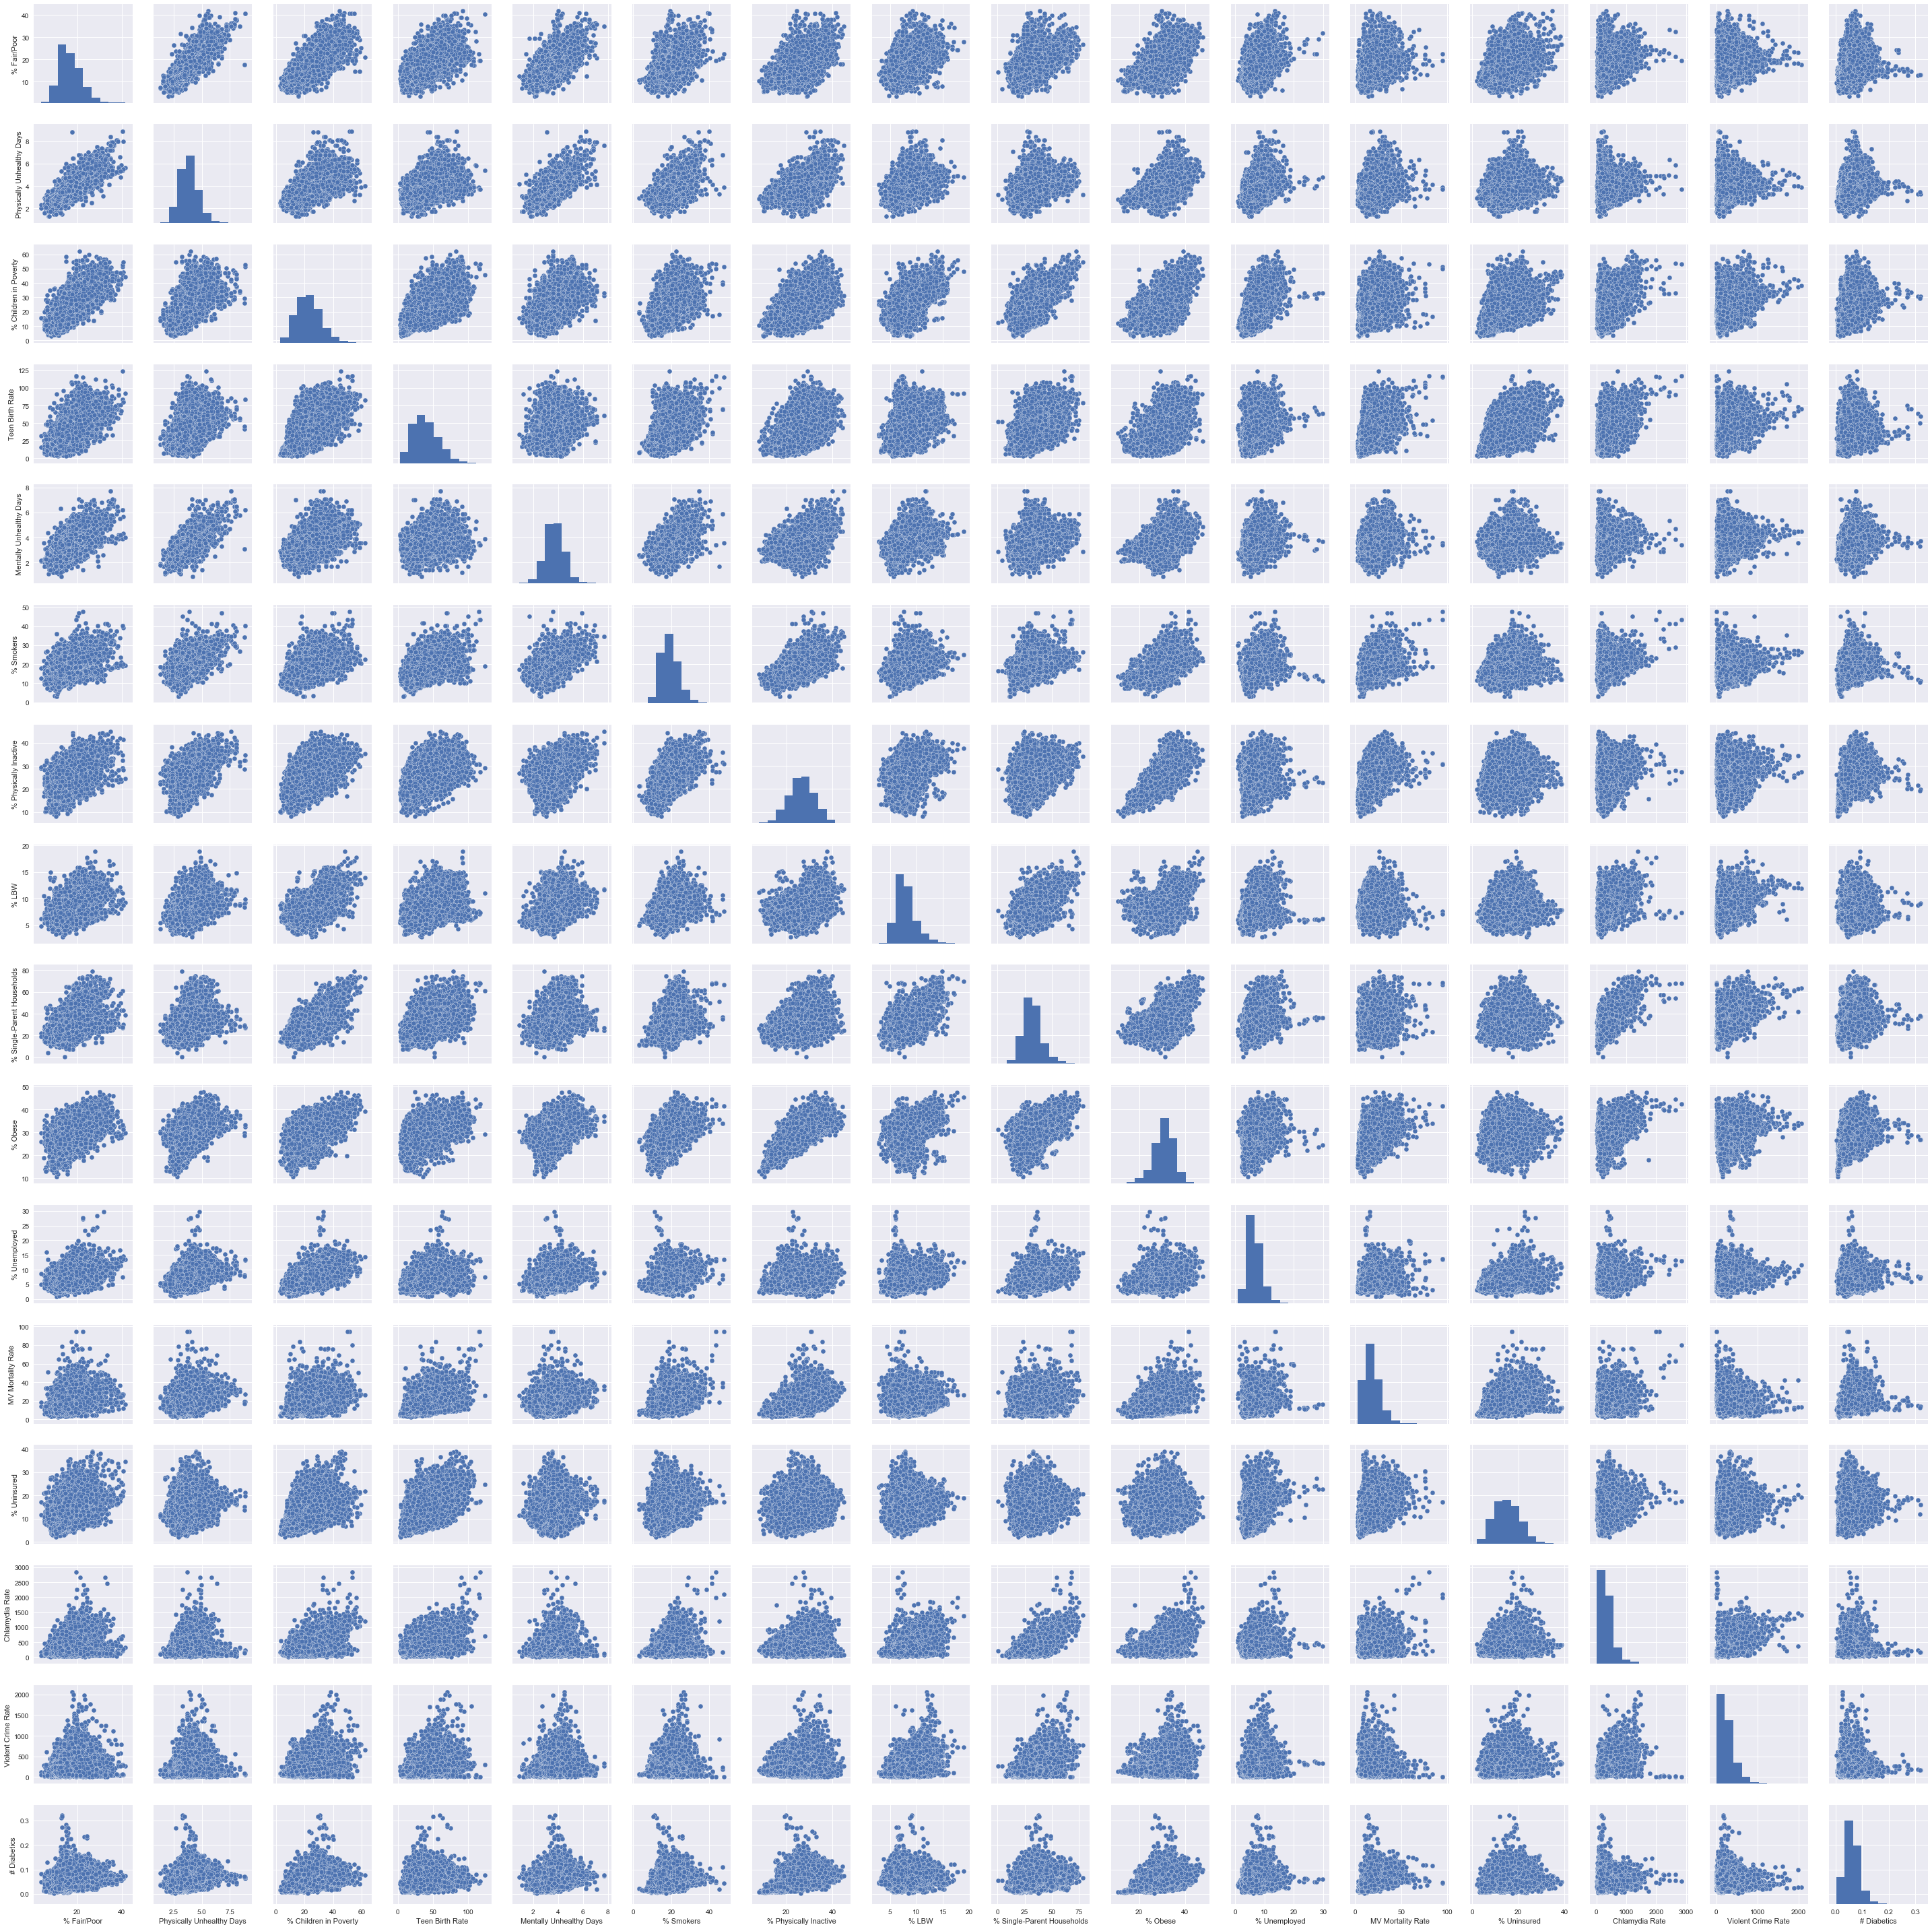

In [40]:
#scatterplot
sns.set()
sns.pairplot(df.loc[:,cols], size = 2.5)

### Look for outliers

left side of the distribution:
[[-2.65780311]
 [-2.61764376]
 [-2.37668768]
 [-2.33652833]
 [-2.33652833]
 [-2.31644866]
 [-2.31644866]
 [-2.31644866]
 [-2.31644866]
 [-2.31644866]]

right side of the distribution:
[[4.49056068]
 [4.56603903]
 [4.57087938]
 [4.57253052]
 [4.71143709]
 [4.75159644]
 [4.75159644]
 [4.7982526 ]
 [4.81183546]
 [4.99255252]]


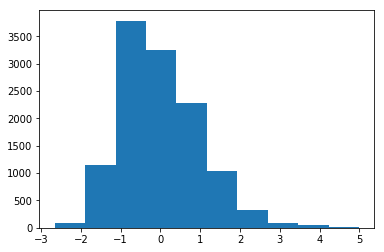

In [15]:
#standardizing data
from sklearn.preprocessing import StandardScaler
# first look for outliers in target variable
health_cond_scaled = StandardScaler().fit_transform(df['% Fair/Poor'][:,np.newaxis]);
low_range = health_cond_scaled[health_cond_scaled[:,0].argsort()][:10]
high_range= health_cond_scaled[health_cond_scaled[:,0].argsort()][-10:]
plt.hist(health_cond_scaled)
print('left side of the distribution:')
print(low_range)
print('\nright side of the distribution:')
print(high_range)


In [16]:
# find indices of outliers
outlier_threshold = 6
outlier_indices = [index for index in range(health_cond_scaled.shape[0]) if np.abs(health_cond_scaled[index]) > outlier_threshold]
# drop outliers
if len(outlier_indices) != 0:
    df.drop([outlier_indices], inplace=True)

### Transform data so that they follow normal distribution?

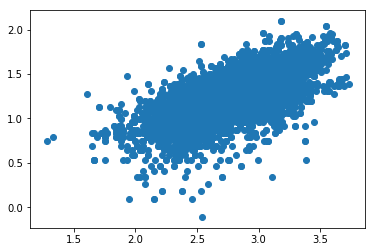

In [17]:
#applying log transformation
df['% Fair/Poor'] = np.log(df['% Fair/Poor'])
df['Mentally Unhealthy Days'] = np.log(df['Mentally Unhealthy Days'])
df['% Children in Poverty'] = np.log(df['% Children in Poverty'])
plt.scatter(df['% Fair/Poor'], df['Mentally Unhealthy Days'])


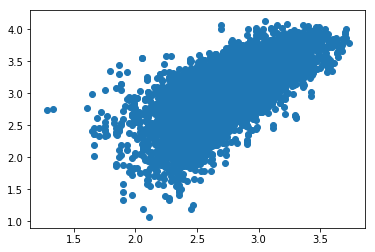

In [18]:
plt.scatter(df['% Fair/Poor'], df['% Children in Poverty'])

((array([-3.8567622 , -3.63415101, -3.51205186, ...,  3.51205186,
          3.63415101,  3.8567622 ]),
  array([1.06471074, 1.19392247, 1.19392247, ..., 4.06902675, 4.08765557,
         4.130355  ])),
 (0.4033187873306776, 3.0538070175195515, 0.9903454795363392))

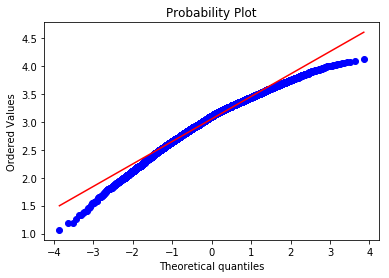

In [19]:
from scipy import stats
stats.probplot(df['% Children in Poverty'], plot=plt)

In [18]:
# the rest of the variables' distributions have left skewness
df.loc[:,cols] = df.loc[:,cols].apply(lambda value: np.log(value))

/Users/yuxinchen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


ValueError: range parameter must be finite.

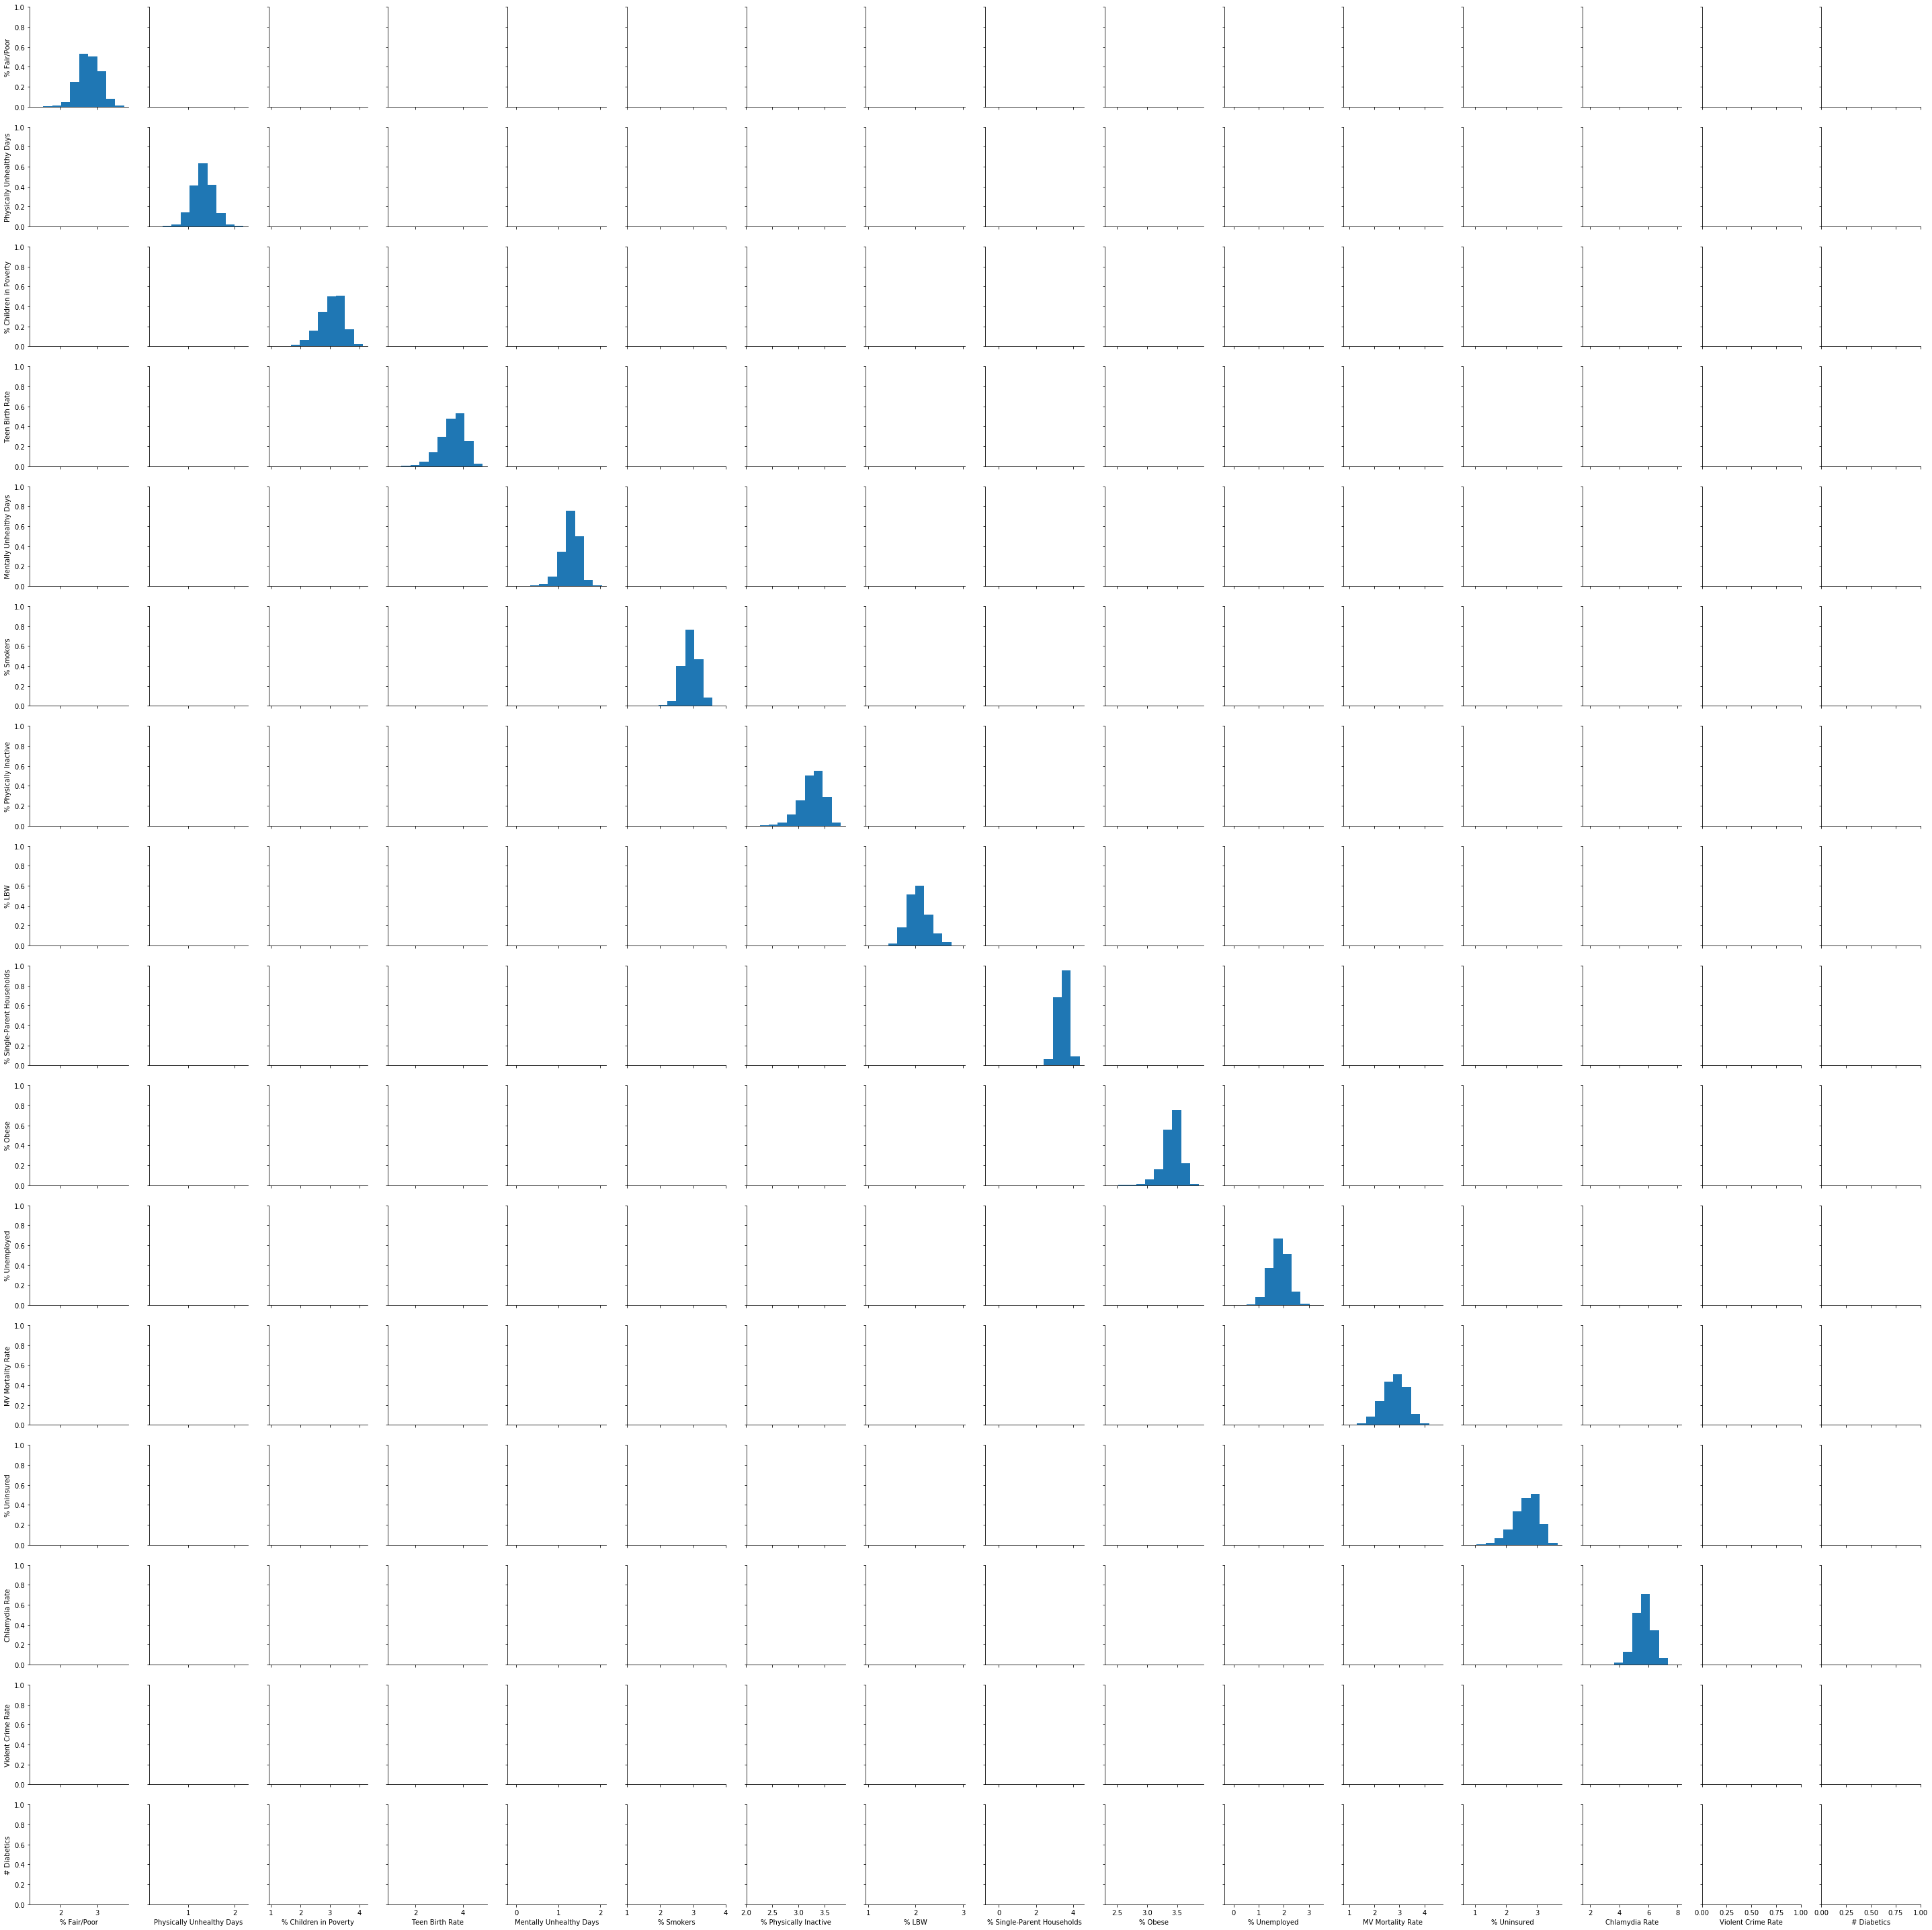

In [19]:
sns.pairplot(df.loc[:,cols], size = 2.5)

### Clustering analysis

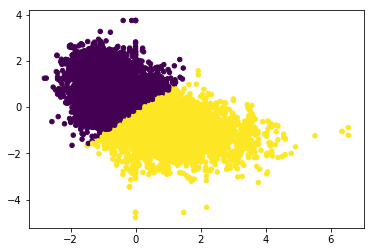

In [52]:
# preprocessing data for clustering algorithms
# subtract by mean and divide by std
numeric_df = df.select_dtypes(include = [np.number])
# numeric_df = df
df_mean = numeric_df.mean()
df_std = numeric_df.std()
numeric_df = (numeric_df - df_mean)/df_std
# from sklearn.cluster import SpectralClustering
X = numeric_df[['% Fair/Poor','% Some College' ]]
# X = numeric_df[['# Diabetics','% Uninsured' ]]
num_clusters = 2
Random_State = 11
# clustering = SpectralClustering(n_clusters=num_clusters,assign_labels="discretize", random_state=Random_State).fit(X)
# y_pred = SpectralClustering(n_clusters=num_clusters, random_state=Random_State).fit_predict(X)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=Random_State).fit(X)
y_pred = KMeans(n_clusters=num_clusters, random_state=Random_State).fit_predict(X)
plt.scatter(X.iloc[:,0],X.iloc[:,1], s=20, c=y_pred)